# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### The notebook contains Conv3D and Conv2D +GRU model.

In [1]:
import numpy as np
import os
from sklearn.preprocessing import normalize
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(40)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
batch_size =32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
img_idx = [k for k in range(0, 30, 2)] #create a list of image numbers you want to use for a particular video
x=len(img_idx)
y=120
z=120
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1]>=(120):
                        #image=image[10:350,10:350,:]
                        image=imresize(image,(y,z,3)).astype(np.float32)
                    else:
                        image=imresize(image,(y,z,3)).astype(np.float32)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =normalize(image[:,:,0]).astype(np.float32) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =normalize(image[:,:,1]).astype(np.float32) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =normalize(image[:,:,2]).astype(np.float32) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                                           # we are pushing out tensor of 32 sequence batch data(with 3 channels) on each generator execution.
            
        
        # write the code for the remaining data points which are left after full batches           
        remaining_folders=len(t) % batch_size
        start_batch=(num_batches*batch_size)
        end_batch=len(t)
        batch=batch+1
        if remaining_folders!=0:
            batch_data = np.zeros((remaining_folders,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_folders,5)) # batch_labels is the one hot representation of the output            
            for folder in range(remaining_folders): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1]>=(100) :
                        #image=image[10:350,10:350,:]
                        image=imresize(image,(y,z,3)).astype(np.float32)
                    else:
                        image=imresize(image,(y,z,3)).astype(np.float32)    #crop the images and resize them. Note that the images are of 2 different shape
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =normalize(image[:,:,0]).astype(np.float32) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =normalize(image[:,:,1]).astype(np.float32) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =normalize(image[:,:,2]).astype(np.float32) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

        



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = os.getcwd()+'/train'
val_path = os.getcwd()+'/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
ges=Sequential()

#First Convolutional layer
ges.add(Conv3D(64, (2,11,11), strides=(1,1,1), input_shape=(x, y, z, 3)))
ges.add(BatchNormalization())
ges.add(Activation('relu'))
ges.add(MaxPooling3D(pool_size=(5,2,2), strides=(1,2,2)))

# Adding dropout
# ges.add(Dropout(.25))

# Second Convolutional Layer
ges.add(Conv3D(32, (3,1,1), strides=(1,1,1)))
ges.add(BatchNormalization())
ges.add(Activation('relu'))
ges.add(MaxPooling3D(pool_size=(5,5,5), strides=(1,2,2))) # padding left


# Third Convolutional Layer
ges.add(Conv3D(32, (2,2,2), strides=(2,2,2)))
ges.add(BatchNormalization())
ges.add(Activation('relu'))
ges.add(MaxPooling3D(pool_size=(2,2,2), strides=(1,1,1))) 
#ges.add(MaxPooling3D(pool_size=(5,5,5), strides=(1,1,1)))


# Adding dropout
# ges.add(Dropout(.25))

# Third Convolutional Layer
#ges.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
#ges.add(BatchNormalization())
#ges.add(Activation('relu'))
#ges.add(MaxPooling3D(pool_size=(2,2,2), strides=(1,1,1)))

# Adding dropout
# ges.add(Dropout(.25))

# Forth Convolutional Layer
#ges.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
#ges.add(BatchNormalization())
#ges.add(Activation('relu'))
#ges.add(MaxPooling3D(pool_size=(2,2,2), strides=(1,1,1)))

# Adding dropout
# ges.add(Dropout(.25))

# Flattening the outputs

ges.add(Flatten())

# Adding Droupout for the Model
ges.add(Dropout(.25))

# Adding Dense layer
ges.add(Dense(512, activation='relu'))

# Adding Droupout for the Model
ges.add(Dropout(.5))

# Adding Dense layer
ges.add(Dense(512, activation='relu'))

# Adding Droupout for the Model
ges.add(Dropout(.5))


# Adding the output layer
ges.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser =optimizers.Adam(lr=.001) #write your optimizer
ges.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (ges.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 14, 110, 110, 64)  46528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 110, 110, 64)  256       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 110, 110, 64)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 55, 55, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 55, 55, 32)     6176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 55, 55, 32)     128       
_________________________________________________________________
activation_2 (Activation)    (None, 8, 55, 55, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
model=ges.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 138s 7s/step - loss: 3.3694 - categorical_accuracy: 0.2306 - val_loss: 2.8163 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-12-2113_37_47.682302/model-00001-3.38089-0.23077-2.81632-0.28000.h5
Epoch 2/30
21/21 [==============================] - 51s 2s/step - loss: 1.7569 - categorical_accuracy: 0.3549 - val_loss: 1.4822 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-12-2113_37_47.682302/model-00002-1.76068-0.35445-1.48215-0.39000.h5
Epoch 3/30
21/21 [==============================] - 51s 2s/step - loss: 1.3763 - categorical_accuracy: 0.4204 - val_loss: 1.1421 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-12-2113_37_47.682302/model-00003-1.37863-0.42081-1.14211-0.58000.h5

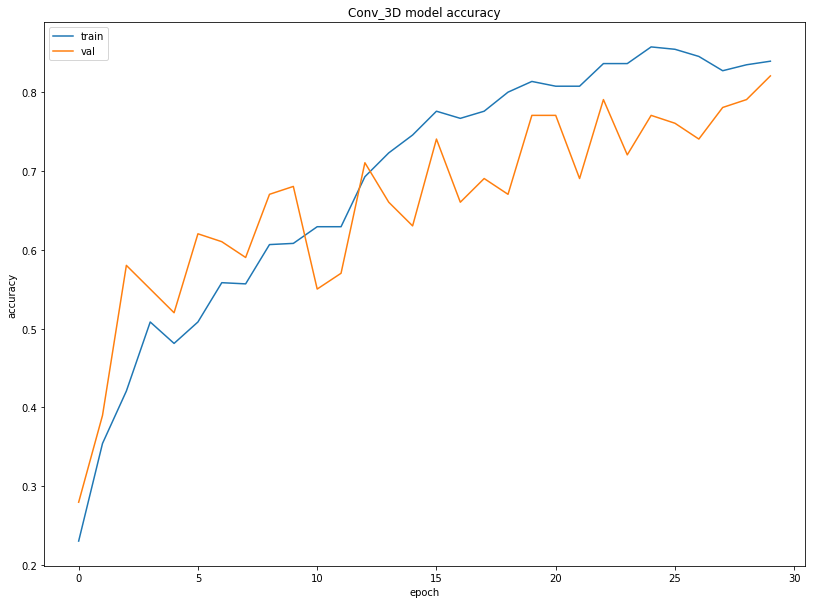

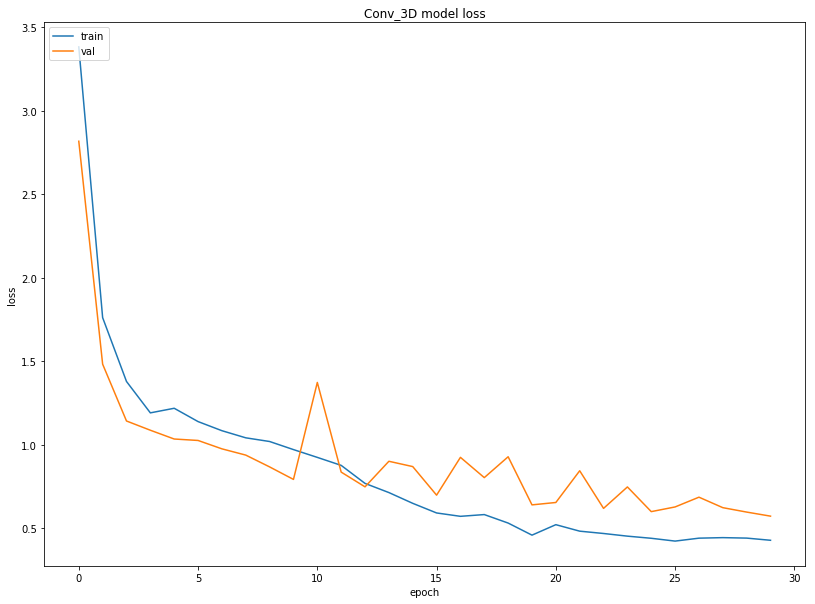

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(121)
# summarize history for accuracy
plt.plot(model.history['categorical_accuracy'])
plt.plot(model.history['val_categorical_accuracy'])
plt.title('Conv_3D model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(30,10))
plt.subplot(122)
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Conv_3D model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
# Model2 CNN_GRU
#write your model here
rnn=Sequential()

#Addcing Convolution layer for timedistributed
rnn.add(TimeDistributed(Conv2D(64,(11,11), strides=(1,1), activation='relu'), input_shape=(x,y,z,3)))
rnn.add(TimeDistributed(BatchNormalization()))
rnn.add(TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=(2,2))))
        
rnn.add(TimeDistributed(Conv2D(32,(3,3), strides=(1,1), activation='relu')))
rnn.add(TimeDistributed(BatchNormalization()))
rnn.add(TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=(3,3))))

rnn.add(TimeDistributed(Conv2D(32,(2,2), strides=(1,1), activation='relu')))
rnn.add(TimeDistributed(BatchNormalization()))
rnn.add(TimeDistributed(MaxPooling2D(pool_size=(3,3), strides=(1,1))))        

rnn.add(TimeDistributed(Flatten()))
rnn.add(TimeDistributed(Dropout(.25)))
rnn.add(TimeDistributed(Dense(512, activation='relu'))) 
rnn.add(TimeDistributed(Dropout(.5))) 
rnn.add(TimeDistributed(Dense(512, activation='relu'))) 
rnn.add(TimeDistributed(Dropout(.5)))
        
rnn.add(GRU(256, activation='relu', return_sequences=False))



rnn.add(Dense(5, activation='softmax'))


In [15]:
rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 110, 110, 64)  23296     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 110, 110, 64)  256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 54, 54, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 52, 52, 32)    18464     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 52, 52, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 17, 17, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 16, 16, 32)    4128      
__________

In [16]:
model=rnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 131s 6s/step - loss: 2.9651 - categorical_accuracy: 0.2507 - val_loss: 3.0322 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-12-2114_57_51.062950/model-00001-2.97699-0.24887-3.03225-0.21000.h5
Epoch 2/30
21/21 [==============================] - 41s 2s/step - loss: 2.2637 - categorical_accuracy: 0.3032 - val_loss: 1.9103 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-12-2114_57_51.062950/model-00002-2.26581-0.30317-1.91028-0.31000.h5
Epoch 3/30
21/21 [==============================] - 43s 2s/step - loss: 1.6327 - categorical_accuracy: 0.3547 - val_loss: 1.4881 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_2020-12-2114_57_51.062950/model-00003-1.63197-0.35596-1.48814-0.36000.h5

21/21 [==============================] - 43s 2s/step - loss: 0.1339 - categorical_accuracy: 0.9613 - val_loss: 1.1272 - val_categorical_accuracy: 0.5700

Epoch 00028: saving model to model_init_2020-12-2114_57_51.062950/model-00028-0.13396-0.96078-1.12724-0.57000.h5
Epoch 29/30
21/21 [==============================] - 42s 2s/step - loss: 0.1177 - categorical_accuracy: 0.9622 - val_loss: 1.1247 - val_categorical_accuracy: 0.5900

Epoch 00029: saving model to model_init_2020-12-2114_57_51.062950/model-00029-0.11777-0.96229-1.12474-0.59000.h5
Epoch 30/30
21/21 [==============================] - 43s 2s/step - loss: 0.1257 - categorical_accuracy: 0.9637 - val_loss: 1.1423 - val_categorical_accuracy: 0.5900

Epoch 00030: saving model to model_init_2020-12-2114_57_51.062950/model-00030-0.12586-0.96380-1.14227-0.59000.h5


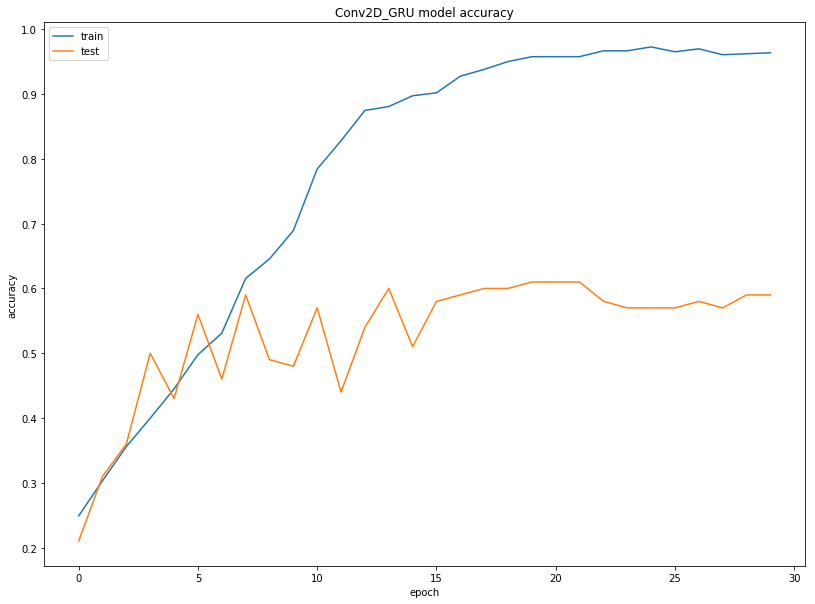

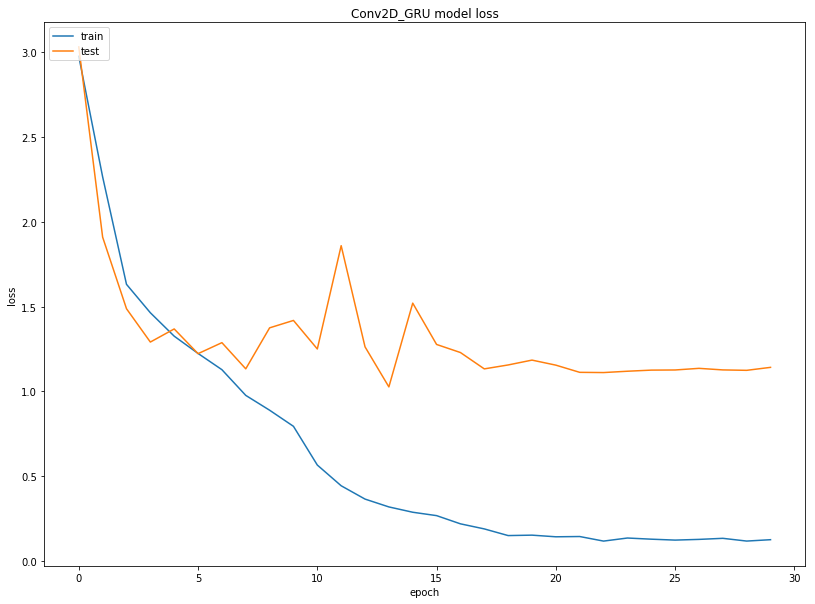

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(121)
# summarize history for accuracy
plt.plot(model.history['categorical_accuracy'])
plt.plot(model.history['val_categorical_accuracy'])
plt.title('Conv2D_GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(30,10))
plt.subplot(122)
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Conv2D_GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusion:

### Based on our observation the performance of Convolution 3D is best out of the two. The ‘.h5’ is available along with this file giving the Training accuracy 83.90% and Validation Accuracy 82.0%. 

## Conv3D
### Train_Accuracy: 0.839
### Val_Accuracy: 0.82

## Conv2D + GRU
### Train_Accuracy: 0.95
### Val_Accuracy: 0.61

